In [104]:
import torchaudio
import numpy as np
from torch import Tensor
from IPython.display import Audio
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from helpers.path_utils import get_base_dir
from helpers.transform import TrimAfterTrigger, min_max_scale
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft

Sample rate:  4000


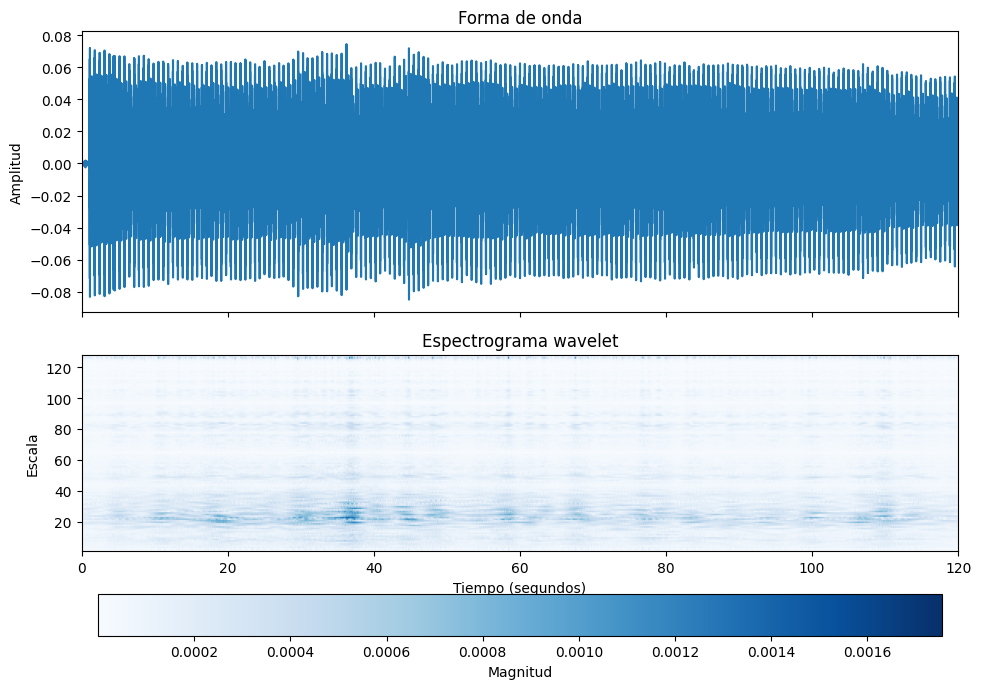

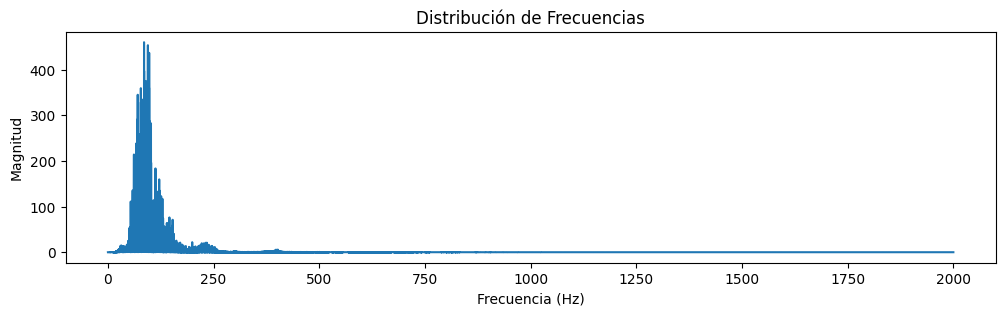

In [105]:
AUDIO_NAME = "SAM-Third Heart Sound.wav"
audio_dir = get_base_dir().joinpath("data", "stethos", "SAM", AUDIO_NAME)

audio, sample_rate = torchaudio.load(str(audio_dir))
print("Sample rate: ", sample_rate)

plot_wavelet_spectrogram(audio.numpy(), sample_rate)  # , downsample_factor=1)
plot_audio_fft(audio.numpy(), sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Snippet to detect hearbeats

In [106]:
SNIPPET_STARTS = 0
SNIPPET_ENDS = 4

cut_starts = int(SNIPPET_STARTS * sample_rate)
cut_ends = int(SNIPPET_ENDS * sample_rate)

snippet = audio[:, cut_starts:cut_ends].clone()
audio.shape, snippet.shape

(torch.Size([1, 480000]), torch.Size([1, 16000]))

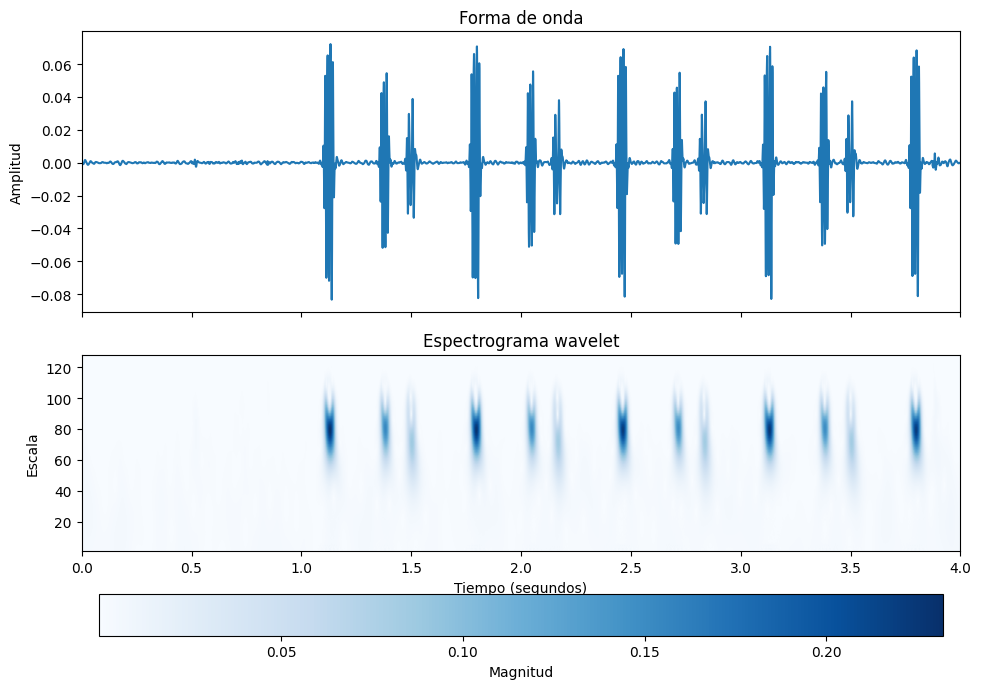

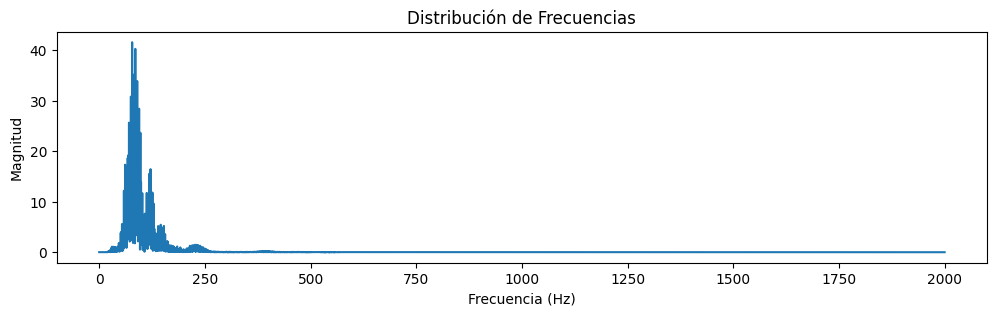

In [107]:
plot_wavelet_spectrogram(snippet, sample_rate, downsample_factor=1)
plot_audio_fft(snippet.numpy(), sample_rate)

Audio(snippet, rate=sample_rate, autoplay=True)

# TrimAfterTrigger class
We can use some methods of that class to detect heartbeats

In [108]:
tat = TrimAfterTrigger()
tat

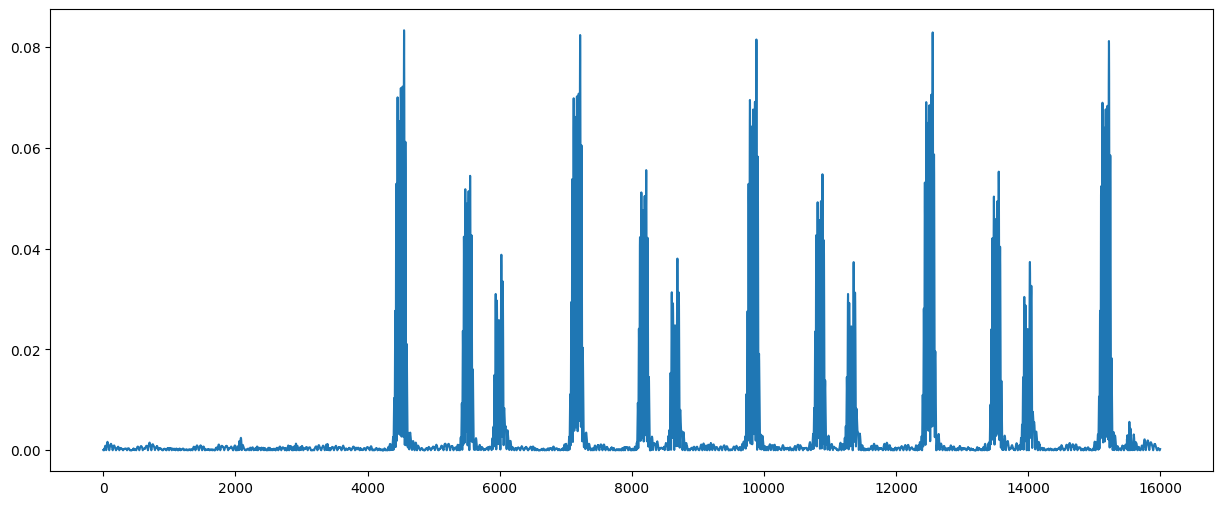

In [109]:
abs_snippet = tat.audio_to_abs(snippet)
plt.figure(figsize=(15, 6))
plt.plot(abs_snippet.squeeze())

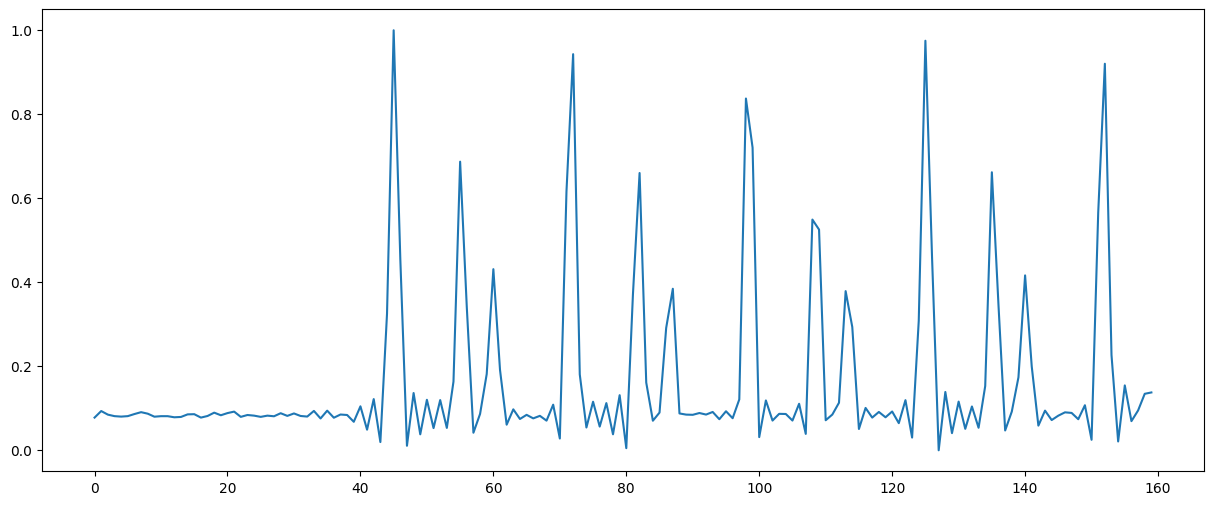

In [110]:
DOWNSAMPLE_FACTOR = 100
downsampled = tat.downsample_audio(abs_snippet, DOWNSAMPLE_FACTOR).copy()
scaled = tat.scale_audio(Tensor(downsampled), scaler=min_max_scale).squeeze()

plt.figure(figsize=(15, 6))
plt.plot(scaled.squeeze())

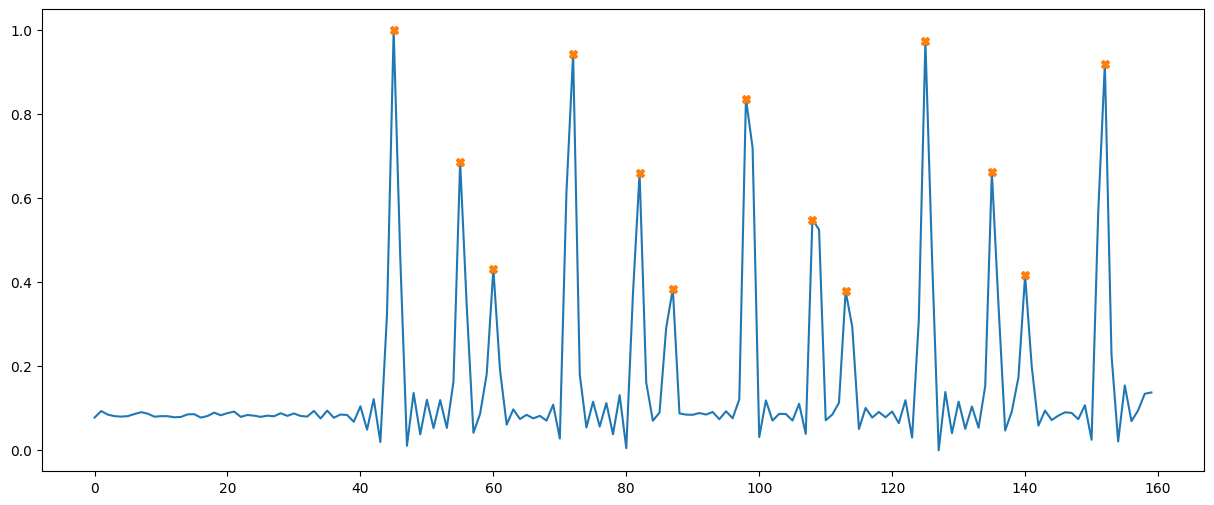

In [111]:
PEAKS_HEIGHT = np.percentile(scaled, 80)
PEAKS_PROMINENCE = 0.2

peaks, _ = find_peaks(scaled, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(scaled)
plt.plot(peaks, scaled[peaks], "X")

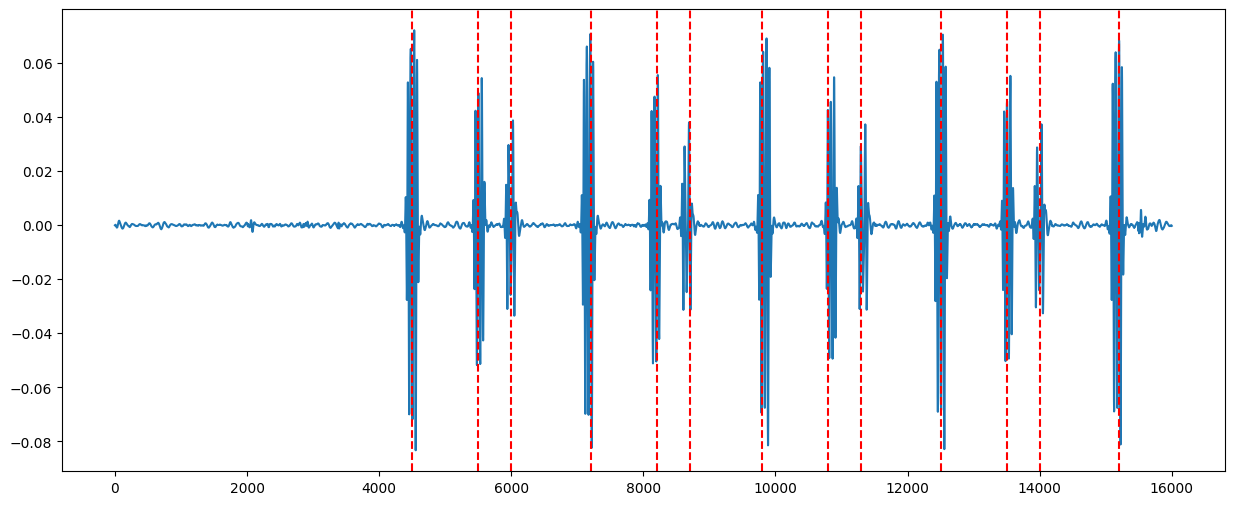

Peaks found in downsampled signal: [ 45  55  60  72  82  87  98 108 113 125 135 140 152]
Peaks in real signal: [ 4500  5500  6000  7200  8200  8700  9800 10800 11300 12500 13500 14000
 15200]
Difference between each: [1000  500 1200 1000  500 1100 1000  500 1200 1000  500 1200]


In [112]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR

plt.figure(figsize=(15, 6))
plt.plot(snippet.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()

print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")
print(f"Difference between each: {np.diff(upsampled_peaks)}")